In [2]:
#| default_exp datasets

In [3]:
#|export
from __future__ import annotations
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F

from datasets import load_dataset,load_dataset_builder

In [4]:
import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

In [5]:
import logging
logging.disable(logging.WARNING)

## Hugging Face Datasets

Note that a list of the available can be found on the Hugging Face hub: 

[Hugging Face Hub](https://huggingface.co/datasets)

In [6]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



The dataset builder has a number of useful properties that can help better understand a dataset.  These are mostly sub properties the info attribute and include:
- features
- splits
- homepage

And lots of other useful things.

Dataset builder allows obtaining details about he dataset without actually downloading it.  Accessing the dataset then uses the load_dataet mehod


In [7]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [8]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [9]:
ds_loader = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

The ds_loader object contains the whole dataset.  We can extact the splits into separate datasets

In [10]:
train_ds, test_ds = ds_loader['train'], ds_loader['test']

In [11]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

The way the Hugging Face datasets work is through the use of dictionaries.  To make it easy to access the values it is easiest to assign the keys into variables so that they can be used to retireve the values more easily

In [12]:
x, y = ds_builder.info.features
x, y

('image', 'label')

Load and display an x value

In [13]:
img = train_ds[0][x]
img

To fully unlock the label it helps to have effectively a conversion.  The dataset features attribute then has a key names, which can be indexed to return the class label for a class index.  The class contains a method int2str to achieve this for a list

In [14]:
featy = train_ds.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [15]:
xb, yb = train_ds[:5][x], train_ds[:5][y]

In [16]:
yb

[9, 0, 0, 3, 0]

In [17]:
yb_labels = featy.int2str(yb)
yb_labels

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [18]:
train_ds[0:3]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 'label': [9, 0, 0]}

#### Creating a collate function to work with this dataset

A function is needed to facilitate loading a batch of data returned from the dataset into stacked torch tensors

input: a batch of data returned by the dataset getitems

In [19]:
def collate_fn(b):
    var_dict = {x: torch.stack([TF.to_tensor(xys[x]) for xys in b]),
                y: tensor([xys[y] for xys in b])}
    return var_dict
    

In [20]:
dl=DataLoader(train_ds, collate_fn=collate_fn, batch_size=16)

In [21]:
batch = next(iter(dl))
batch[y]

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])

In [22]:
batch[x].shape

torch.Size([16, 1, 28, 28])

#### Start to build the transforms into the dataloader process 

In [23]:
def transforms(batch):
    # Note that this will only process the x values
    batch[x] = [TF.to_tensor(xys) for xys in batch[x]]
    return batch

The Hugging Face dataset contains a method with_transform that applies a transform to a batch immediately before it is returned.  It looks as though it automatically converts the y values into a torch array

In [24]:
tls = train_ds.with_transform(transforms)
dl = DataLoader(tls, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]


(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

The image needs to be flattened prior to returning and so the transforms can be modified

In [25]:
def _transformi(batch):
    # Note that this will only process the x values
    batch[x] = [torch.flatten(TF.to_tensor(xys)) for xys in batch[x]]
    return batch

Don't fully understand the inplace function below.  It looks as though when a function is called it returns the new value over the existing value

In [26]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [27]:
transformi = inplace(_transformi)

In [28]:
r = train_ds.with_transform(transformi)[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

The above function can then be used as a decorator

In [29]:
@inplace
def transformi(batch): batch[x] = [torch.flatten(TF.to_tensor(xbs)) for xbs in batch[x]]

In [30]:
tdsf = train_ds.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

#### Add in the collate_dict

In [31]:
class Demo():
    def __getitem__(self, k):
        return 1 if k=='a' else 2 if k=='b' else 3

In [32]:
demo = Demo()
demo['a']

1

Adding in the itemgetter function, which is a way to return a tuple of items based upon a variable length set of inputs.  Note that it only returns the highest level of the class properties.  The * before the variable makes it look for multiple inputs, and I think it therefore picks the keys adn not the values one level down

In [33]:
ig = itemgetter('a', 'c')
ig(demo)

(1, 3)

The batch returned from the dataset provides data in the form below:

In [34]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
batch

({'a': [1], 'b': [2]}, {'a': [3], 'b': [4]})

In [35]:
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [36]:
# This will get the properties 'image', 'label' from whatever it is used against
get = itemgetter(*tdsf.features)
get

operator.itemgetter('image', 'label')

In [37]:
# This function will get the values associated wiht the keys defined in get.  In other words it will 
# return a list of tensors for image and label
def _f(b): return get(default_collate(b))

In [38]:
#|export
def collate_dict(ds):
    """ when a dataset is defined by a dictionary this will identify the features and split into inputs and outputs
    as tensor arrays ready for input to a model
    """
    get = itemgetter(*ds.features)
    def _f(b): 
        # return a tuple containing the values associated with each of the keys returned by the itemgetter
        # given that default_collate return a dict with two keys and a stacked tensor for each
        return get(default_collate(b))
    return _f

Putting it all together we get tdsf as a dataset (which returns values that have had any required transforms applied.  Collate_dict(ds) return a function that will process the data it is supplied with (b) but use the itemgetter defined for the dataset (ie by the dataset features).  This is why it is necessary to pass in tdsf when defining the dataloader.  ds is not what is applied by the dataloader, it is the function returned by collate_dict when setup for the appropriate type , ie by setting the itemgetter to select the correct dictionary keys

In [39]:
test_fn = collate_dict(tdsf)

In [40]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,xb = next(iter(dlf))
xb.shape,yb

(torch.Size([4]), [9, 0, 0, 3, 0])

In [41]:
# Create a mini-batch to test the collate function.  This is as it would be supplied from the data loader
# to the collate function
mini_batch = [tdsf[i] for i in range(4)]
mini_batch[0]['image'].shape

torch.Size([784])

Feeding the mini-batch through the collate function gives the required outputs

In [42]:
collate_dict(tdsf)(mini_batch)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 0, 0, 3]))

## Plotting Images
Plotting can be done using the matplotlib function imshow, however, this is cumbersome to setup in a way that makes it easy to use with a variable number of images, applying labels and configuring correctly.  A way to improve that is developed here.  This makes use of the fastcore library to understand available kwargs, which can often be a problem 

imshow features to include:
variable figsize
input ax if required
Assign tiles to the overall plot
set a frame or not
pass in kwargs to imshow

Permute axis if required from CHW to HWC
Convert to array if required
Create axes if required
remove ticks from axis
Remove empty channel axis if only one channel

Return the image as an axis

In [43]:
from matplotlib.pyplot import axes as ax

In [44]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(img, ax=None, title=None, noframe=True, figsize=None, **kwargs):
    # prepare images.  Check if pytorch tensor by using attributes
    if fc.hasattrs(img, ('cpu', 'permute', 'detach')):
        img = img.detach().cpu()
        if len(img.shape)==3 and img.shape[0]<8:
            img = img.permute(1,2,0)
        elif not isinstance(img, np.ndarray):
            img = np.asarray(img)
    # If only one channel remove the dimension
    if img.shape[-1] == 1:
        img = img[...,0]
    # if axes do not exist then create them
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    # plot the array
    ax.imshow(img, **kwargs)
    # Add a title
    if title is not None: ax.set_title(title)
    # turn off tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    # Finally set whether or not to show a frame
    if noframe:
        ax.axis('off')
    return ax

The fastcore library now gives a list of all of the parameters that can be passed as kwargs, for example interpolation.

In [45]:
help(show_image)

Help on function show_image in module __main__:

show_image(img, ax=None, title=None, noframe=True, figsize=None, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    #|export



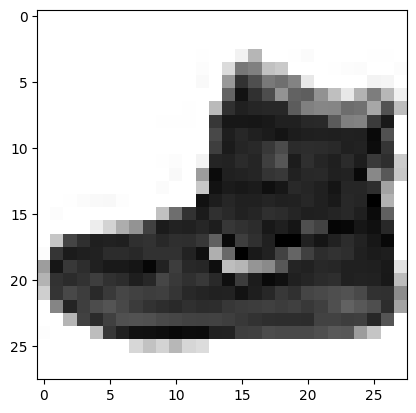

In [46]:
# Load a sample image to display
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0])

 Now use the above show image function to display the image

<AxesSubplot: title={'center': 'test'}>

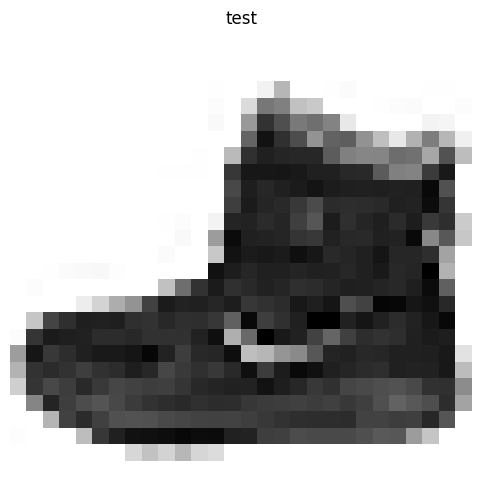

In [47]:
show_image(img, figsize=(6,6), title = "test")

#### From show_image to suplots to show multiple images
It is often necessary to plot multiple images in a grid.  To do so effectively it is necessary to size the imaged appropriated and to only show images where one exists (ie empty spots on the grid should reamin empty. ALso we need to make sure we can add labels to each image

In [48]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int=1, # Number of rows
    ncols: int=1, # Number of columns
    figsize: tuple =None, #Size of overall figure that will be produced in default units
    imsize: float = 3, # size of individual images in default units
    suptitle: str = None, # Title for the plot
    **kwargs
    ) -> (plt.Figure, plt.Axes):
    """ create grid of axes ready for assignment of images to each axis

        nrows (int): number of rows
        ncols (int): number of columns
        figsize (Tuple[float, float]): Size of overall figure that will be produced in default units
        imsize (float): size of individual images in default units
        suptitle (Union[str, None]): title for the overall figure


        fig: plt.Figure
        ax: np.array(plt.Axes)
    """
    # calculate fig size if not supplied
    if figsize is None:
        figsize = (ncols*imsize, nrows*imsize)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)

    # If only one axes then turn into a array to allow consistent processing (multiple axes are stored as arrays)
    if ncols*nrows==1: ax=array([ax])
    return fig, ax  

In [49]:
from nbdev.showdoc import show_doc

The showdoc method generates a summary of the arguments for the subplots function but also includes the aspects that can be set using kwargs, which can be very helpful

At present it does not seem to work very well with traditional docstrings, as can be seen below.

In [50]:
show_doc(subplots)

---

[source](https://github.com/fastai/fastai-course-22p/blob/master/miniai/datasets.py#L68){target="_blank" style="float:right; font-size:smaller"}

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:float=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                width_ratios=None, height_ratios=None, subplot_kw=None,
>                gridspec_kw=None, **kwargs)

create grid of axes ready for assignment of images to each axis

nrows (int): number of rows
ncols (int): number of columns
figsize (Tuple[float, float]): Size of overall figure that will be produced in default units
imsize (float): size of individual images in default units
suptitle (Union[str, None]): title for the overall figure

fig: plt.Figure
ax: np.array(plt.Axes)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows |
| ncols | int | 1 | Number of columns |
| figsize | tuple | None | Size of overall figure that will be produced in default units |
| imsize | float | 3 | size of individual images in default units |
| suptitle | str | None | Title for the plot |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| width_ratios | NoneType | None |  |
| height_ratios | NoneType | None |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |
| **Returns** | **(plt.Figure, plt.Axes)** |  |  |

The above call can be used as follows:

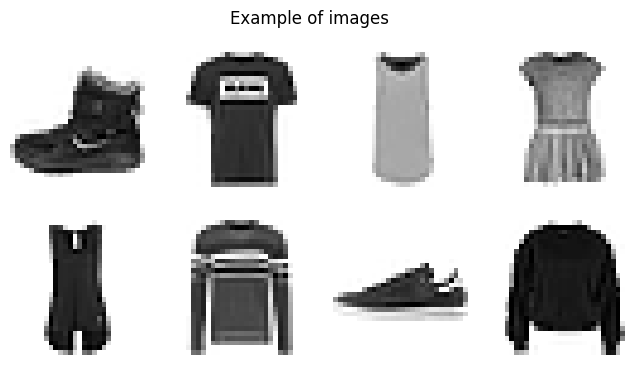

In [51]:
fig, axs = subplots(nrows=2, ncols=4, imsize=2, suptitle="Example of images")
imgs = xb[:8]
for ax, img in zip(axs.flat, imgs): show_image(img, ax)

We can make the function more intelligent by automatically calculating the size of the images and allowing the title to have weight and size defined.  This function can be built on top of the subplots method above

In [ ]:
#|export
@fc.delegates(subplots)
def get_grid(
    n: int, # Number of axes
    nrows: int=None, # Number of rows
    ncols: int=None, # Number of columns
    title: str=None, # Plot title, optional
    weight: str='bold', # Weight to apply to the title
    size: int=14, # size of the title font
    **kwargs
    
):
    # "Return a grid of n axes over a combination of rows and columns."
    # If the rows are specified then ncols will be used if specified but if not then the columns needed
    # will be calculated.  Note that "or" will return the first value unless it is None, when it returns 
    # the second
    if nrows: ncols = ncols or int(np.ceil(n/nrows))
    elif ncols: nrows = int(np.ceil(n/ncols))
    else:
        nrows = int(np.ceil(math.sqrt(n)))
        ncols = int(np.ceil(n/nrows))
    _ = kwargs.pop('cmap', None)
    # Avoid passing cmap to subplots
    fig, axs = subplots(nrows, ncols, **kwargs)
    # Turn of the display of axis
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    # Add the title if necessary
    if title: 
        fig.suptitle(title, weight=weight, size=size)
    return fig, axs

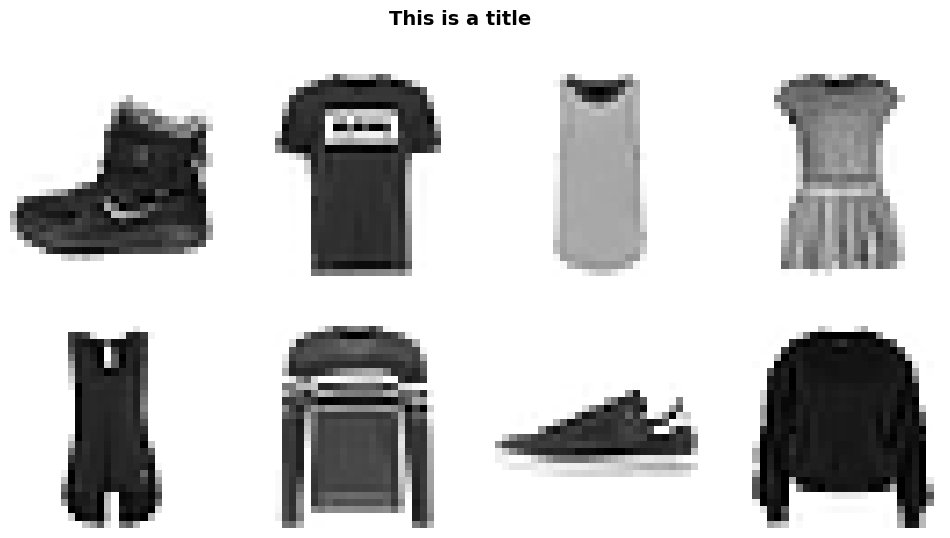

In [72]:
fig, axs = get_grid(8, nrows=2, title="This is a title")
for ax, img in zip(axs.flat, imgs): show_image(img, ax)

Finally it is possible to now create a show_images function that uses show image to display individual images and get_grid to provide the grid of axes upon which to plot them.  We will also pass in the labels for each object so that this can be used as a title for each image

In [81]:
#|export
@fc.delegates(subplots)
def show_images(
    imgs: list, # List of images to show
    nrows: int=1, # Number of rows
    ncols: int=None, # Number of columns
    titles: str=None, # Plot title, optional, list of titles for each image
    **kwargs
):
    # Create a grid of axes ready to plot the images
    axs = get_grid(len(imgs), **kwargs)[1].flat
    # import pdb; pdb.set_trace()
    # Remove unwanted kwargs
    _ = kwargs.pop('imsize', None)
    _ = kwargs.pop('title', None)
    # plot images and individual labels
    for img, t, ax in zip_longest(imgs, titles or [], axs[:len(imgs)]):
        show_image(img, ax, t, **kwargs)
    

In [82]:
b = next(iter(dl))
xb = b['image'][:8]
yb = b['label'][:8]

In [83]:
names = featy.names
# itemgetter will lookup the item in the following object and attempt to retrieve it by the "key" given
# in this case the key is taken as an index, since the object that follows is a list
labels = itemgetter(*yb)(names)

In [84]:
labels

('Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover')

In [85]:
len(xb), len(labels)

(8, 8)

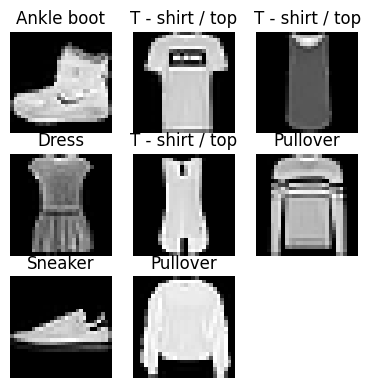

In [90]:
show_images(xb, titles=labels, nrows=2, imsize=1.5, cmap='gray')

## Export 

In [3]:
import nbdev; nbdev.nbdev_export()